# 目录
## 1. [利率二叉树](#1.利率二叉树)
## 2. [因子分析基础](#2.因子分析基础)
&emsp;&emsp;2.1. [计算各股票关于沪深300的beta](#2.1.计算各股票关于沪深300的beta)    
&emsp;&emsp;2.2. [优化求解](#2.2.优化求解)    
&emsp;&emsp;2.3. [求夏普比例最大的全额投资组合](#2.3.求夏普比例最大的全额投资组合)    
## 3. [国债期货分类算法](#3.国债期货分类算法)
&emsp;&emsp;3.1. [清洗形成一个日频率的数据文件](#3.1.清洗形成一个日频率的数据文件)    
&emsp;&emsp;3.2. [机器学习对label的正负进行分类判断以及结果展示](#3.2.机器学习对label的正负进行分类判断以及结果展示)    
&emsp;&emsp;3.2.1. [数据预处理与探索性分析](#3.2.1.数据预处理与探索性分析)  
&emsp;&emsp;3.2.2. [模型训练](#3.2.2.模型训练)   
&emsp;&emsp;3.2.3. [模型评价](#3.2.3.模型评价)   

# 1.利率二叉树 
我的解答如下，计算结果亦在excel中展示。

<div style="width:image width px; font-size:100%; text-align:center;"><img src='利率二叉树1.JPG' alt="alternate text" width="width" height="height"  /> 利率二叉树 1 </div>
<div style="width:image width px; font-size:100%; text-align:center;"><img src='利率二叉树2.JPG' alt="alternate text" width="width" height="height"  /> 利率二叉树 2 </div>

# 2.因子分析基础
## 2.1.计算各股票关于沪深300的beta
1. 数据是各股票及沪深300近10年的月收益率，求各股票关于沪深300的beta？

In [1]:
import math
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings("ignore")

In [37]:
hs300=pd.read_excel('笔试题.xlsx',sheet_name='数据_因子分析基础',index_col=0)

#namaes: ['泸州老窖', '古井贡酒', '酒鬼酒', '五粮液', '顺鑫农业', '洋河股份', '贵州茅台', '老白干酒', '山西汾酒', '沪深300']
names=hs300.columns.tolist()

cov_matrix=np.cov(hs300.T)
#选取最后一行提取各股票与HS300的协方差，去掉最后一个HS300与自身的协方差。
hs300_cov=cov_matrix[-1][:-1]
#再除以HS300的方差，对应协方差矩阵最后一项
hs300_beta=hs300_cov/cov_matrix[-1][-1]
hs300_beta_result=pd.DataFrame({'股票名称':names[:-1],'Beta':hs300_beta})
hs300_beta_result
#hs300_beta_result.to_excel("关于沪深三百的Beta.xlsx",index=None)

,股票名称,Beta
0,泸州老窖,0.922795
1,古井贡酒,1.109248
2,酒鬼酒,0.702688
3,五粮液,0.785685
4,顺鑫农业,0.843506
5,洋河股份,0.846409
6,贵州茅台,0.624224
7,老白干酒,1.302673
8,山西汾酒,0.998766


## 2.2.优化求解
2. 记f为各股票的超额收益，V为各股票的协方差矩阵，h为各股票的权重，求解下列优化问题

对于每只股票的超额收益，我认为是这样计算的，如下所示：  
- $\delta_i$表示当月的变化率，一共10年，每年12个月，一共120期。最后，再将它折算成10年的年变动率$\delta$，最后再用 $\delta$-2.5% 得到超额收益率$f_i$。  
$$\prod_{i=1}^{120}(1+\delta_i)=(1+\delta)^{10}$$  
$$f_i=\delta-2.5%$$  

In [59]:
#计算每只股票超额收益
fi=pow((hs300.iloc[:,:-1]+1).prod(),0.1)-1.025
fi

泸州老窖    0.058031
古井贡酒    0.123665
酒鬼酒     0.054581
五粮液     0.129350
顺鑫农业    0.090426
洋河股份   -0.028105
贵州茅台    0.189226
老白干酒   -0.101828
山西汾酒    0.051473
dtype: float64

In [114]:
cov_matrix_9=np.cov(hs300.iloc[:,:-1].T)#包含9支股票，除了hs300的协方差矩阵，即矩阵V
fi=np.array(fi).reshape(-1,1)#转换成列向量
# h size: 9*1 -- to be solved
# V size: 9*9
# f size: 9*1
def objective(x):
    result=x.T@cov_matrix_9@x#友情提示：@表示矩阵乘法
    return result.reshape(-1)[0]
 
#约束条件，包括等式约束和不等式约束
#eq表示 函数结果等于0 ； ineq 表示 表达式大于等于0
cons = ({'type': 'eq', 'fun': lambda x: (fi.T@x).reshape(-1)[0]-1})

#解最优解
x=np.ones((9,1))#h的初始值全设定为1
sol = minimize(objective, x, method='SLSQP', constraints=cons)
print(sol)

     fun: 0.08467210415887222
     jac: array([ 0.00987455,  0.02083514,  0.00928303,  0.02192898,  0.01517003,
       -0.004771  ,  0.03210187, -0.01724238,  0.00881609])
 message: 'Optimization terminated successfully.'
    nfev: 286
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([-2.03817255,  0.72563884, -0.0775525 ,  1.67221627,  0.43380401,
       -1.41998092,  3.38251312, -1.01183391, -0.11179642])


In [115]:
q2_result=pd.DataFrame({'股票名称':names[:-1],'权重':sol.x})
q2_result

,股票名称,权重
0,泸州老窖,-2.038173
1,古井贡酒,0.725639
2,酒鬼酒,-0.077553
3,五粮液,1.672216
4,顺鑫农业,0.433804
5,洋河股份,-1.419981
6,贵州茅台,3.382513
7,老白干酒,-1.011834
8,山西汾酒,-0.111796


## 2.3.求夏普比例最大的全额投资组合
若以月来衡量，每月的无风险收益率应为$\sqrt[12]{1.025}-1=2.0598\%$  
接下来的步骤演示了如何求每只股票的sharpe ratio，及其结果。

In [111]:
#新建一个dataframe
hs300new=hs300.iloc[:,:-1]
#新建一列代表无风险收益率
risk_free=pd.Series([pow(1.025,1/12)-1 for i in range(120)],index=hs300new.index)
#相减得到超额收益
excess_returns = hs300new.sub(risk_free,axis=0)
avg_excess_return = excess_returns.mean()
#标准差
sd_excess_return = excess_returns.std(ddof=1)#使用样本，因此自由度为1
sharpe_ratio = avg_excess_return.div(sd_excess_return)
sharpe_ratio

泸州老窖    0.095645
古井贡酒    0.139527
酒鬼酒     0.101881
五粮液     0.150516
顺鑫农业    0.116963
洋河股份    0.046420
贵州茅台    0.202428
老白干酒    0.019562
山西汾酒    0.102073
dtype: float64

In [148]:
# 目标函数：夏普比率
# h size: 9*1
def objective(x):
    excess_returns=(np.array(hs300new)@x).reshape(-1)-np.array(risk_free)
    avg_excess_return = excess_returns.mean()
    sd_excess_return = excess_returns.std(ddof=1)#使用样本，因此自由度为1
    sharpe_ratio = avg_excess_return/sd_excess_return
    return -sharpe_ratio#由于默认是最小化，因此加上负号

In [149]:
#尝试，如果都取1/9，sharpe ratio为0.13
objective(np.array([1/9 for i in range(9)]))

-0.13483845697190797

In [150]:
#约束条件，包括等式约束和不等式约束
#eq表示 函数结果等于0 ； ineq 表示 表达式大于等于0
cons = ({'type': 'eq', 'fun': lambda x: sum(x)-1})

#解最优解
x=np.array([1/9 for i in range(9)])#h的初始值全设定为1
sol = minimize(objective, x, method='SLSQP',bounds=[(0.0,1.0) for i in range(9)], constraints=cons)
print(sol)

     fun: -0.207229321105539
     jac: array([ 0.04424106, -0.02404699, -0.02400673, -0.00782677, -0.02369946,
        0.08778312, -0.02398361,  0.13333631,  0.02590518])
 message: 'Optimization terminated successfully.'
    nfev: 121
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.00000000e+00, 6.55690577e-02, 2.53900774e-02, 0.00000000e+00,
       1.06686674e-01, 0.00000000e+00, 8.02354191e-01, 0.00000000e+00,
       2.34879483e-18])


In [153]:
q3_result=pd.DataFrame({'股票名称':names[:-1],'权重':sol.x})
q3_result

,股票名称,权重
0,泸州老窖,0.000000e+00
1,古井贡酒,6.556906e-02
2,酒鬼酒,2.539008e-02
3,五粮液,0.000000e+00
4,顺鑫农业,1.066867e-01
5,洋河股份,0.000000e+00
6,贵州茅台,8.023542e-01
7,老白干酒,0.000000e+00
8,山西汾酒,2.348795e-18


从结果可见，当取以上权重时，sharpe ratio最大，达到了0.2072。

## 2.4.计算各股票关于组合Q的Beta

In [162]:
hs300Q=hs300.iloc[:,:-1]
hs300Q['Q']=hs300Q@sol.x.T
Q_cov_matrix=np.cov(hs300Q.T)
#选取最后一行提取各股票与Q的协方差，去掉最后一个Q与自身的协方差。
Q_cov=cov_matrix[-1][:-1]
#再除以Q的方差，对应协方差矩阵最后一项
Q_beta=Q_cov/Q_cov_matrix[-1][-1]
Q_beta_result=pd.DataFrame({'股票名称':names[:-1],'Beta':Q_beta})
Q_beta_result

,股票名称,Beta
0,泸州老窖,0.588783
1,古井贡酒,0.707748
2,酒鬼酒,0.448346
3,五粮液,0.501301
4,顺鑫农业,0.538193
5,洋河股份,0.540046
6,贵州茅台,0.398282
7,老白干酒,0.831162
8,山西汾酒,0.637256


In [171]:
#计算Q的超额收益
fq=pow((hs300.iloc[:,:-1]@sol.x.T+1).prod(),0.1)-1.025
fq

0.18814168004853582

In [177]:
# 验证股票i的超额收益f_i = f_Q * Beta_i （近似）
fi.reshape(-1)-fq*Q_beta

array([-0.05274365, -0.00949241, -0.0297712 ,  0.03503394, -0.01083015,
       -0.12970979,  0.11429274, -0.25820418, -0.06842142])

CAPM模型的论证： 
portfolio Q（组合 Q ）是最高夏普率的全额投资组合（在预期超额收益率等于1的投资组合中找风险最小的组合）。  
假设：1. 所有投资者都有均值/方差偏好；2. 所有投资者都知道资产的预期超额收益率f ；3. 所有投资者对所有资产的方差和协方差有一致观点。
<div style="width:image width px; font-size:100%; text-align:center;"><img src='Q2-4.png' alt="alternate text" width="width" height="height"  /> </div>  


在这些假设下，理性投资者都会购买组合Q，或者由组合Q和无风险资产M按某种比例组成的投资组合，这样，每个投资者的投资组合都会落在图中FQF`的直线上。由于整个市场的总借入资金和总借出资金会相互抵消，因此所有投资者的资产组合汇总在一起必然构成市场组合M，也就是组合Q。

# 3.国债期货分类算法
## 3.1清洗形成一个日频率的数据文件
1. 从附件的data_raw文件中提取数据（其中windcode是指不同资产的代码），并清洗形成一个日频率的数据文件，特征包括各类别资产9：30-10点的收益率和各类别资产14：30-15点的收益率 （可以参考data_preprocessed)

In [2]:
#读取数据并将index转化为时间格式
raw_data=pd.read_csv('data_raw.csv',index_col=0)
raw_data.index=pd.to_datetime(raw_data.index) 

#提取日期，小时，分钟作为新列，为计算收益率做准备
raw_data['date']=raw_data.index.date
raw_data['hour']=raw_data.index.hour
raw_data['minute']=raw_data.index.minute
raw_data

,windcode,close,position,volume,date,hour,minute
2017-10-23 09:15:00,T.CFE,94.0350,69316.0,1022.0,2017-10-23,9,15
2017-10-23 09:16:00,T.CFE,94.0550,69336.0,487.0,2017-10-23,9,16
2017-10-23 09:17:00,T.CFE,94.0700,69333.0,371.0,2017-10-23,9,17
2017-10-23 09:18:00,T.CFE,94.0800,69335.0,145.0,2017-10-23,9,18
2017-10-23 09:19:00,T.CFE,94.0800,69409.0,200.0,2017-10-23,9,19
...,...,...,...,...,...,...,...
2020-10-22 14:56:00,000001.SH,3312.8375,NaN,111758000.0,2020-10-22,14,56
2020-10-22 14:57:00,000001.SH,3312.5310,NaN,9115200.0,2020-10-22,14,57
2020-10-22 14:58:00,000001.SH,NaN,NaN,0.0,2020-10-22,14,58
2020-10-22 14:59:00,000001.SH,NaN,NaN,0.0,2020-10-22,14,59


In [3]:
#计算时间1和2之间的收益率
def cal_return(x,hour1,minute1,hour2,minute2):
    value1=x[(x['hour']==hour1)&(x['minute']==minute1)]['close'][0]
    value2=x[(x['hour']==hour2)&(x['minute']==minute2)]['close'][0]
    return (value2-value1)/value1

#将两个收益率合并成dataframe格式，并指定列名
def combine_two_return(r1,r2):
    return pd.DataFrame({'9:30-10:00\'s Return':[r1],'14:30-15:00\'s Return':[r2]})

#通过groupby按股票名和日期分割，计算9：30-10：00与14：30-15：00之间的收益率
grouped_table=raw_data.groupby(['windcode','date']).apply(lambda x: combine_two_return(cal_return(x,9,30,10,0),cal_return(x,14,30,15,0)))
grouped_table

9:30-10:00's Return  14:30-15:00's Return
windcode  date                                                   
000001.SH 2017-10-23 0            -0.000763              0.000056
          2017-10-24 0             0.002690              0.001496
          2017-10-25 0             0.000470              0.001129
          2017-10-26 0             0.002102              0.000690
          2017-10-27 0             0.002639             -0.000015
...                                     ...                   ...
TF.CFE    2020-10-16 0            -0.000554              0.000252
          2020-10-19 0             0.000603              0.000301
          2020-10-20 0            -0.000301              0.000251
          2020-10-21 0             0.000552              0.000201
          2020-10-22 0             0.000651              0.000250

[3650 rows x 2 columns]

In [4]:
#合并Index，导出结果
final_table=grouped_table.reset_index().drop('level_2',axis=1)#去掉一列多余的Index,得到最终的收益率
final_table
#final_table.to_excel("所有股票的日频率数据文件.xlsx",index=None)

,windcode,date,9:30-10:00's Return,14:30-15:00's Return
0,000001.SH,2017-10-23,-0.000763,0.000056
1,000001.SH,2017-10-24,0.002690,0.001496
2,000001.SH,2017-10-25,0.000470,0.001129
3,000001.SH,2017-10-26,0.002102,0.000690
4,000001.SH,2017-10-27,0.002639,-0.000015
...,...,...,...,...
3645,TF.CFE,2020-10-16,-0.000554,0.000252
3646,TF.CFE,2020-10-19,0.000603,0.000301
3647,TF.CFE,2020-10-20,-0.000301,0.000251
3648,TF.CFE,2020-10-21,0.000552,0.000201


## 3.2.机器学习对label的正负进行分类判断以及结果展示
2.从附件的data_preprocessed文件中提取数据，label是标签，其他是特征。请寻找合适的算法通过的特征的数值对label的正负进行分类判断。  
3.通过matplotlib或pyecharts等工具对上面的结果进行各种角度的展示，不提倡用seaborns

### 3.2.1.数据预处理与探索性分析

In [2]:
data_preprocessed=pd.read_csv('data_preprocessed.csv',index_col=0)
data_preprocessed.describe()

,label,gain_1,gain_2,volume1,volume2,volume_sh,sh,gc001,volume_gc001,gc007,volume_gc007
count,730.000000,666.000000,666.000000,730.000000,730.000000,7.300000e+02,730.000000,730.000000,7.300000e+02,730.000000,7.300000e+02
mean,0.000020,0.000019,0.000030,4329.235616,7252.458904,1.815125e+10,0.000634,2.960757,4.310354e+08,3.017869,8.690779e+07
std,0.000850,0.000636,0.000785,2482.068932,3418.484597,8.572277e+09,0.008955,1.331774,6.363750e+07,1.086811,3.937351e+07
min,-0.004517,-0.002815,-0.003466,716.000000,2323.000000,7.554397e+09,-0.033791,0.904127,2.471810e+08,1.340867,2.354590e+07
25%,-0.000425,-0.000369,-0.000460,2749.750000,4962.250000,1.226563e+10,-0.004375,2.390835,3.867400e+08,2.466755,6.110932e+07
50%,0.000000,0.000025,0.000051,3801.500000,6382.500000,1.589921e+10,0.000218,2.769005,4.218112e+08,2.794915,7.906605e+07
75%,0.000460,0.000425,0.000528,5229.750000,8597.000000,2.118643e+10,0.004885,3.127159,4.667972e+08,3.276618,1.010071e+08
max,0.004048,0.003021,0.003044,18793.000000,25827.000000,5.858105e+10,0.037370,15.932441,7.850189e+08,12.968294,4.888425e+08


首先观察目标变量label，通过下列计算可以得到有19个label为0，因此需要将他们剔除。然后将label大于0的分为正类，记作1，小于0的分为负类，记作0.

In [3]:
(data_preprocessed['label']==0).sum()

19

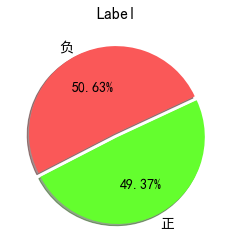

In [4]:
data_preprocessed=data_preprocessed[data_preprocessed['label']!=0]
data_preprocessed['label']=data_preprocessed['label'].apply(lambda x:int(x+1))

f, ax = plt.subplots(1,1, figsize=(4,4))
colors = ["#FA5858", "#64FE2E"]
labels ="负","正"

ax.set_title('Label', fontsize=16)
data_preprocessed['label'].value_counts().plot.pie(explode=[0,0.05], autopct='%1.2f%%', ax=ax, shadow=True, colors=colors,labels=labels, fontsize=14, startangle=25)
plt.axis('off')
plt.show()

根据上方的结果，正样本占50.63%，负样本占49.37%。因此不存在样本不平衡的情况，所以在本例中我们不需要进行过采样或是欠采样以使正负样本数目平衡。  


接下来我们通过关系矩阵查看各特征之间的关系，如下图所示。  
小小的解释：这里用到seaborn包的原因是，画相关性矩阵的最常用的工具就是seaborn包中已经封装好的`heatmap()`函数，因此只在此处使用。pyecharts并没有使用的原因是：其实我有用pyecharts画地图的经历，但是本文用matplotlib的目的是为了更快的展示结果，如后续工作中需要做出更精美的图片我也愿意用pyecharts慢慢调整。

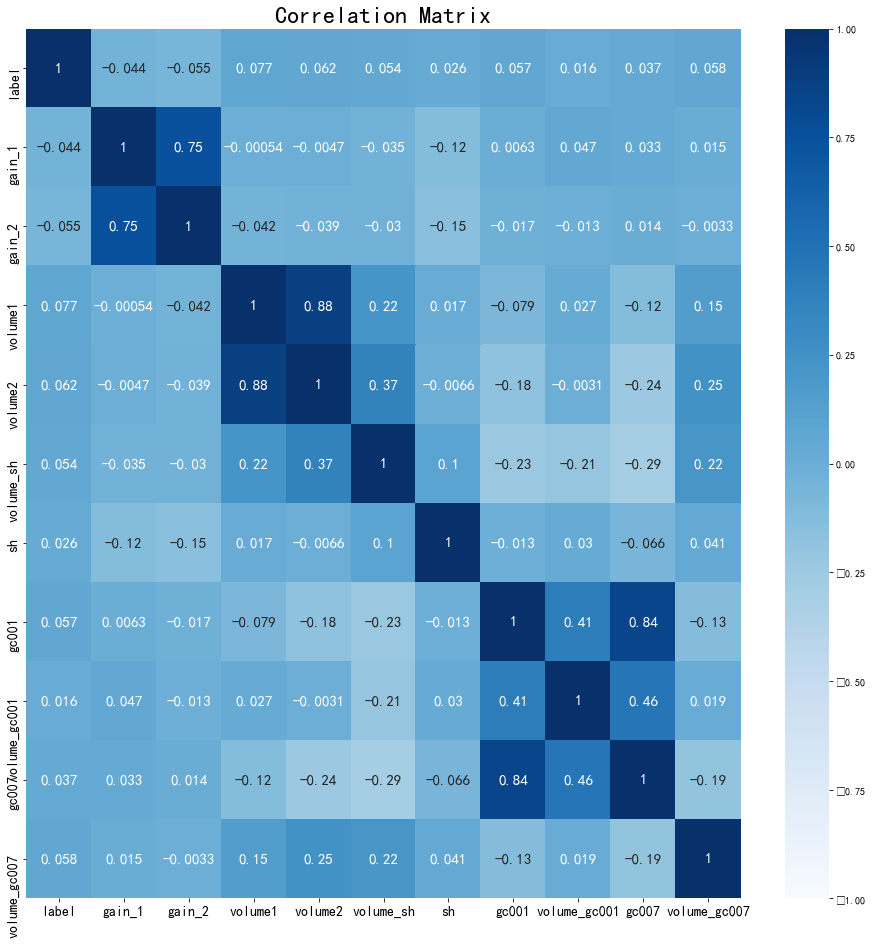

In [5]:
fig, ax = plt.subplots(figsize=(16, 16))
corr_matrix = data_preprocessed.corr()#关系矩阵，以矩阵形式存储

sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, cmap="Blues",annot_kws={"size":15})#热力图，即关系矩阵
ax.set_title("Correlation Matrix", fontsize=24)
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)
plt.show()

通过相关性矩阵可以看出，没有一个变量与我们的目标变量`label`有很强的相关性，而`volumn1`,`volumn2`和`volumn_sh`之间，以及`gc001`,`volumn_gc001`和`gc007`之间产生了较强的相关性。

接下来查看各变量的分布情况。

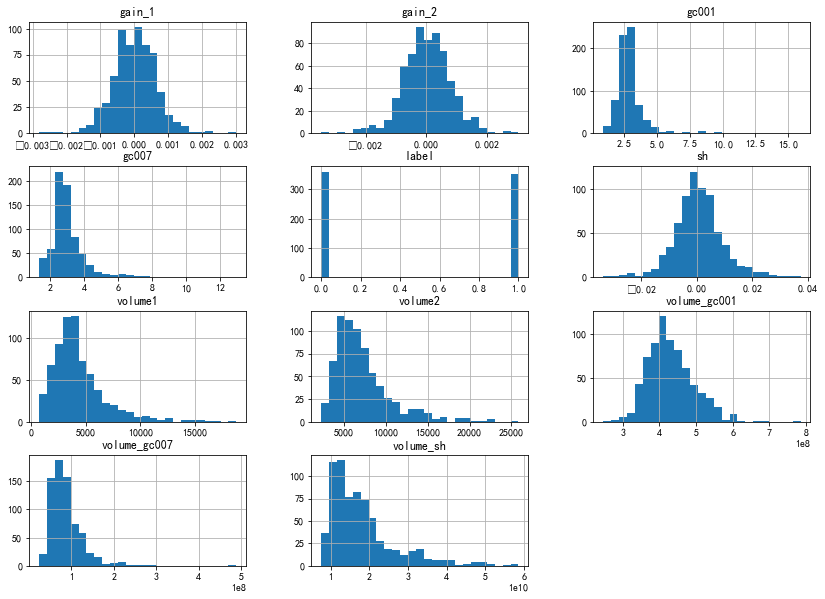

In [6]:
data_preprocessed.hist(bins=25, figsize=(14,10))
plt.show()

通过观察数据我们可以看出,`gain_1`,`gain_2`和`sh`变量的分布是均匀的，而其他变量呈现右偏。这里有两种处理方法，一种是对数据进行Box-Cox转换，或者简而言之，对右偏的变量进行log-transform；另一种是对所有变量进行标准化。这里我采用对所有变量进行标准化的方法。

此外，我从数据中观察到`gain_1`和`gain_2`变量存在缺失值，观察缺失值的时间段可知，两者均在2019年12月12日与2020年7月20日到2020年10月22日之间缺失，由于缺失的数量（66条）相对于没有缺失样本的总数（649条）显得少得多，因此可以将它们剔除。

In [7]:
#查看缺失样本
data_preprocessed[(data_preprocessed['gain_1'].isna())|(data_preprocessed['gain_2'].isna())]

,label,gain_1,gain_2,volume1,volume2,volume_sh,sh,gc001,volume_gc001,gc007,volume_gc007
2019-12-12,1,NaN,NaN,2424.0,3881.0,1.274697e+10,-0.001225,2.715666,360639700.0,2.745096,81632800.0
2020-07-20,0,NaN,NaN,1223.0,7356.0,3.675556e+10,0.017530,2.030132,409208300.0,2.202264,154504800.0
2020-07-21,0,NaN,NaN,2204.0,9117.0,3.197358e+10,-0.001884,1.869136,415054200.0,2.048845,107101900.0
2020-07-22,0,NaN,NaN,1383.0,7905.0,3.387616e+10,0.010870,1.808120,405210000.0,2.011796,125194300.0
2020-07-23,1,NaN,NaN,2095.0,11047.0,3.654160e+10,0.004009,1.910270,426646900.0,2.164847,71353600.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-16,0,NaN,NaN,1481.0,6151.0,1.708634e+10,-0.002803,1.973227,445005000.0,2.326020,167726200.0
2020-10-19,0,NaN,NaN,1145.0,5120.0,1.877128e+10,-0.011351,2.219933,445055400.0,2.505815,154599700.0
2020-10-20,0,NaN,NaN,1504.0,6153.0,1.397936e+10,0.005158,2.513017,430190700.0,2.668702,93562800.0
2020-10-21,1,NaN,NaN,1220.0,4945.0,1.540027e+10,-0.002085,2.472888,442385500.0,2.514257,89047500.0


In [8]:
#去掉带有缺失值的部分
data_preprocessed=data_preprocessed[(~data_preprocessed['gain_1'].isna())&(~data_preprocessed['gain_2'].isna())]
data_preprocessed

,label,gain_1,gain_2,volume1,volume2,volume_sh,sh,gc001,volume_gc001,gc007,volume_gc007
2017-10-23,0,0.000425,0.000638,3804.0,5610.0,1.105595e+10,-0.000786,3.133582,501123100.0,3.702374,82954500.0
2017-10-24,0,-0.000319,-0.000212,1685.0,2704.0,1.199298e+10,0.002433,2.989961,500140100.0,3.786179,55705600.0
2017-10-25,1,-0.000425,-0.000319,4342.0,6689.0,1.008653e+10,0.002609,3.054381,499537100.0,4.111958,73129400.0
2017-10-26,0,-0.001121,-0.002349,5295.0,14623.0,1.592717e+10,0.003664,3.652973,496650800.0,4.199696,67018500.0
2017-10-27,1,-0.000960,-0.000960,4509.0,6771.0,1.439348e+10,0.004064,4.798455,478022400.0,4.647910,54646600.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,1,-0.000761,-0.000761,6846.0,14806.0,4.966459e+10,0.010481,2.201666,409723100.0,2.367794,149147400.0
2020-07-14,0,0.000760,-0.000152,10890.0,16748.0,4.856714e+10,-0.002862,2.055028,414519800.0,2.151670,94414300.0
2020-07-15,0,-0.001065,0.000355,12658.0,18778.0,4.273669e+10,-0.012272,2.036750,415837400.0,2.204417,111460900.0
2020-07-16,0,0.000455,0.000354,7334.0,14209.0,4.133557e+10,-0.033791,2.078733,431825300.0,2.244253,90070300.0


在处理缺失值时，我还有另外的思考：如果`gain_1`和`gain_2`对目标`y`的影响不大时，是否可以去掉这里两个变量而不是去掉多余的数据呢？  
但为了保险起见，我还是选择带着这两个变量一起做。最后可以在树模型的feature importance部分查看每个特征的贡献度来判断是否需要加入`gain_1`和`gain_2`。

In [9]:
#提取X和y
X=data_preprocessed.drop(['label'], axis=1)
y=data_preprocessed['label']
#标准化X
sc=StandardScaler()
X = sc.fit_transform(X)
#划分训练集与测试集
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=10)

关于划分数据集的思考：既可以像我这里一样随机划分，也可以根据此案例中的数据的时序特征，用17-19年的数据来预测20年的数据。但我考虑到疫情对20年的特殊影响，最后还是决定随机划分，80%训练集，20%测试集。  



### 3.2.2.模型训练


由于该样本是平衡样本，因此不需要进行过采样或者欠采样，数据预处理的流程已在3.1.1中完成。  
接下来我们分别尝试机器学习的8种常用模型进行对比，同时，我们进行3-折交叉验证以提高准确度。评价标准采用ROC曲线下的面积——AUC值。  


In [23]:
t_diff=[]
# 逻辑回归
log_reg = LogisticRegression()
t_start = time.clock()#通过time记录
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
log_reg_mean = log_scores.mean()

# S支持向量机
svc_clf = SVC(probability=True)
t_start = time.clock()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
svc_mean = svc_scores.mean()

# k邻近
knn_clf = KNeighborsClassifier()
t_start = time.clock()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
knn_mean = knn_scores.mean()

# 决策树
tree_clf = tree.DecisionTreeClassifier()
t_start = time.clock()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
tree_mean = tree_scores.mean()

# 梯度提升树
grad_clf = GradientBoostingClassifier()
t_start = time.clock()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
grad_mean = grad_scores.mean()

# 随机森林
rand_clf = RandomForestClassifier()
t_start = time.clock()
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
rand_mean = rand_scores.mean()

# 神经网络
neural_clf = MLPClassifier(alpha=0.01)
t_start = time.clock()
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
neural_mean = neural_scores.mean()

# 朴素贝叶斯
nav_clf = GaussianNB()
t_start = time.clock()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
nav_mean = neural_scores.mean()

d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean],
    'time':t_diff}

result_df = pd.DataFrame(d)
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)


运行的结果如下：  
- 标准化后的交叉验证结果

|    | Classifiers       |   Crossval Mean Scores |      time |
|---:|:------------------|-----------------------:|----------:|
|  4 | Grad B CLF        |               0.511811 | 0.274006  |
|  0 | Logistic Reg.     |               0.497953 | 0.0126667 |
|  1 | SVC               |               0.484003 | 0.0147401 |
|  5 | Rand FC           |               0.480556 | 0.270881  |
|  2 | KNN               |               0.470973 | 0.0080997 |
|  6 | Neural Classifier |               0.46832  | 0.756766  |
|  7 | Naives Bayes      |               0.46832  | 0.0047353 |
|  3 | Dec Tree          |               0.451505 | 0.0091903 |

- 未经标准化的交叉验证结果

|    | Classifiers       |   Crossval Mean Scores |      time |
|---:|:------------------|-----------------------:|----------:|
|  1 | SVC               |               0.559615 | 0.0173278 |
|  0 | Logistic Reg.     |               0.554537 | 0.0203413 |
|  2 | KNN               |               0.512853 | 0.0087741 |
|  4 | Grad B CLF        |               0.509005 | 0.276152  |
|  6 | Neural Classifier |               0.502183 | 0.637717  |
|  7 | Naives Bayes      |               0.502183 | 0.0067507 |
|  5 | Rand FC           |               0.475497 | 0.274632  |
|  3 | Dec Tree          |               0.468657 | 0.0115246 |

在一开始使用标准化后的X进行预测时，我惊讶的发现大部分的单个机器学习模型的验证集预测准auc值竟然不到50%。  
这首先说明它存在严重的过拟合问题，其次仅有梯度提升树一个集成模型达到了50%以上的auc，而随机森林表现不佳。说明梯度提升树在该问题中表现较好。   
另外，我猜测：如果不经过标准化的话，结果会不会变好，因此我把未经标准化的交叉验证结果也放在了上面，SVM和逻辑回归的表现远远好于其他分类器，达到了55%以上。因此，基于梯度提升树是基于树模型的特点，是否标准化并不会对它产生影响，因此最终我决定不使用标准化。

### 3.2.3.模型评价
接下来我对表现最好的三个分类器（LR,SVM,Boosing）进行调参。

In [11]:
X=data_preprocessed.drop(['label'], axis=1)
y=data_preprocessed['label']

In [15]:
Cs = [1e-5, 0.01, 0.1, 1, 10, 100, 1000,1e5]
tuned_parameters = dict(C = Cs)
 
lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1)
grid.fit(X,y)
 
lr_results=pd.DataFrame(grid.cv_results_)
lr_results[['params','mean_train_score','mean_test_score','rank_test_score']]

,params,mean_train_score,mean_test_score,rank_test_score
0,{'C': 1e-05},0.537054,0.518919,1
1,{'C': 0.01},0.537054,0.518919,1
2,{'C': 0.1},0.537054,0.518919,1
3,{'C': 1},0.537054,0.518919,1
4,{'C': 10},0.537054,0.518919,1
5,{'C': 100},0.537054,0.518919,1
6,{'C': 1000},0.537054,0.518919,1
7,{'C': 100000.0},0.537054,0.518919,1


由逻辑回归的结果可知，无论怎样调整它的参数C，最终都取得了相同的auc得分。

In [20]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1e-2,1e-1,1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1e-2,1e-1,1, 10, 100, 1000]}]
 
svm_penalty= SVC(max_iter=1000)
grid= GridSearchCV(svm_penalty, tuned_parameters,cv=5, scoring='roc_auc',return_train_score=True,n_jobs=-1)
grid.fit(X,y)
 
svm_results=pd.DataFrame(grid.cv_results_)
svm_results[['params','mean_train_score','mean_test_score','rank_test_score']]

,params,mean_train_score,mean_test_score,rank_test_score
0,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.500000,7
1,"{'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,0.500000,7
2,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.500000,7
3,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,0.500000,7
4,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.500000,7
5,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,0.500000,7
6,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.500000,7
7,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,0.500000,7
8,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.500000,7
9,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,0.500000,7


SVM的训练花了很长的时间，说明样本本身确实难以分开，模型很难对最优的支持向量做出决定。这里限定迭代轮数为1000轮后，发现所有线性核的表现一样，训练auc与测试auc都在0.55左右，表现略好于逻辑回归。

最后，由于GradientBoosting的调参过程过多，这里不作为重点展示。我这里想要展示每个特征的重要性（贡献度），如下所示：

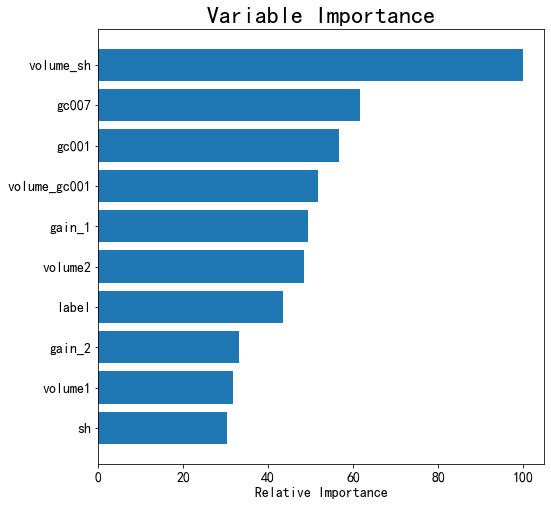

In [35]:
grad_clf=GradientBoostingClassifier()
grad_clf.fit(X,y)
feature_importance = grad_clf.feature_importances_#每个特征重要性值
feature_importance = 100.0 * (feature_importance / feature_importance.max())#将最大特征重要性值为1，其他的都是占比
sorted_idx = np.argsort(feature_importance)#np.argsort返回值从小到大排序后对应索引的位置
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')#feature_importance[sorted_idx]根据索引位置取值
plt.yticks(pos, data_preprocessed.columns[sorted_idx])
plt.xlabel('Relative Importance',fontdict={'size':14})

ax.set_title("Variable Importance", fontsize=24)
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)


plt.show()

由图可见，`volumn_h`的贡献度最大。

最后，我讲可视化ROC曲线，以观察最好的三个模型的效果。

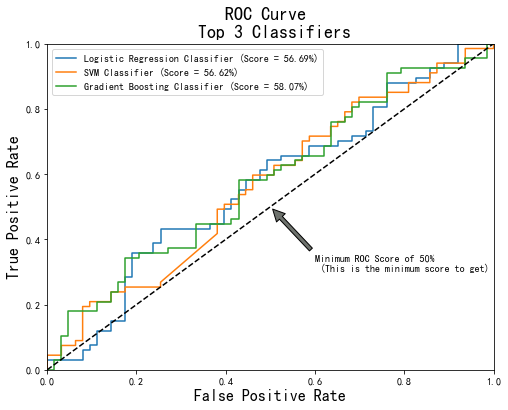

In [24]:
#通过该函数获得一个分类器的AUC值与ROC曲线的参数
def get_auc(clf):
    clf=clf.fit(X_train, y_train)
    prob=clf.predict_proba(X_test)
    prob=prob[:, 1]
    return roc_auc_score(y_test, prob),roc_curve(y_test, prob)

#画ROC曲线与计算AUC
log_roc_scores,log_roc_curve = get_auc(log_reg)
svc_roc_scores,svc_roc_curve = get_auc(svc_clf)
grad_roc_scores,grad_roc_curve = get_auc(grad_clf)

log_fpr, log_tpr, log_thresold = log_roc_curve
svc_fpr, svc_tpr, svc_threshold = svc_roc_curve
grad_fpr, grad_tpr, grad_threshold = grad_roc_curve

def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, grad_fpr, grad_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier (Score = {:.2%})'.format(log_roc_scores))
    plt.plot(svc_fpr, svc_tpr, label='SVM Classifier (Score = {:.2%})'.format(svc_roc_scores))
    plt.plot(grad_fpr, grad_tpr, label='Gradient Boosting Classifier (Score = {:.2%})'.format(grad_roc_scores))
    plt.plot([0, 1], [0, 1], 'k--')#指定x,y轴的坐标在0，1之间
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()#显示图例
    
graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, grad_fpr, grad_tpr)
plt.show()

- 总结  
在最好的三个方法（LR,SVM,Gradient Boosting）中，Gradient Boosting取得了58.07%的AUC值，表现最好。虽然label很难分清，但是借助机器学习我们的确可以获得比直接猜测（50%）更优秀的结果。